### This notebook desrcibes the steps taken to utilize the AutoAlbument AutoML tool to learn image augmentation policies.

In [1]:
#import torch.utils.data
import torch
import os
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, utils, models
from torch import nn, optim
from collections import OrderedDict

In [2]:
class LipoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        # Create a list of filepaths of images and the respective label
        self.samples = []

        for i in os.listdir(root_dir):
            if i in ["positive", 'negative']:
                folder = os.path.join(root_dir, i)
                target = folder.split("/")[-1]
                for label in os.listdir(folder):
                    filepath = os.path.join(folder, label)
                    self.samples.append((target, filepath))


    def __len__(self):
        # Get the length of the samples 
        return len(self.samples)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.
        
        # get the filepath of the image based on the index and convert it to 
        # color scale and then into a numpy array
        image = np.array(Image.open(self.samples[index][1]).convert("RGB"))

        # maps a label to an integer value
        label_to_int = {"positive": 1, "negative": 0}
        label = label_to_int[self.samples[index][0]]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [4]:
# test if the above class works and outputs the appropriate info
if __name__ == '__main__':
    dataset = LipoDataset('../input/lipodata/data/data/train')
    print(len(dataset))
    print(dataset[0][0].shape)

183
(385, 429, 3)


In [5]:
# check if cuda is available 
torch.cuda.is_available()

True

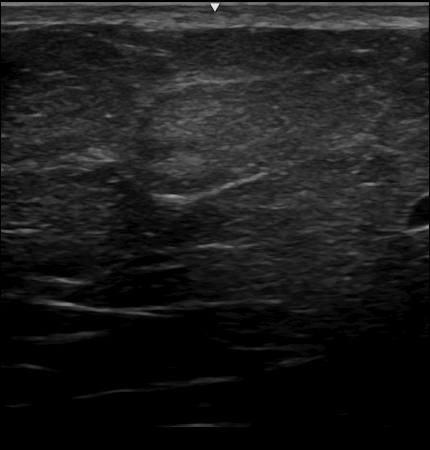

In [7]:
# example of an image
Image.open('../input/lipodata/data/data/train/positive/USLH053_04.png').convert('L')

In [9]:
# convert image RGB scale and then into a numpy array
img = np.array(Image.open('../input/lipodata/data/data/train/positive/USLH053_04.png').convert('RGB'))

In [11]:
# load the augmentation policy learned by the autoalbument ML model 
# and transform the above image
transform = A.load("../input/lipodata/epoch_20.json")
transformed = transform(image=img)
transformed_image = transformed["image"]

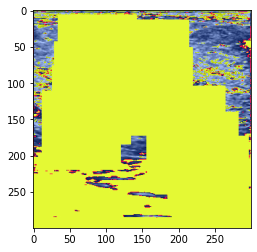

In [12]:
# plot the image 
%matplotlib inline


reverse_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    np.array,
])

plt.imshow(reverse_preprocess(transformed_image));

In [13]:
# create a dataset and tranform the images 
dataset = LipoDataset('../input/lipodata/data/data/train', transform=transform)
v_dataset = LipoDataset('../input/lipodata/data/data/val', transform=transform)

In [14]:
# create a dataloader 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8, shuffle=True)

In [15]:
# use the baseline model to see if it improves the result 
densenet = models.densenet121(pretrained=True)

new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 1))
]))
densenet.classifier = new_layers

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet.to(device);

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [16]:
# use existing training function to determine if transformations improve accuracy 
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

Epoch 1: Train Accuracy: 0.53. Valid Accuracy: 0.51.
Epoch 2: Train Accuracy: 0.63. Valid Accuracy: 0.46.
Epoch 3: Train Accuracy: 0.62. Valid Accuracy: 0.53.
Epoch 4: Train Accuracy: 0.53. Valid Accuracy: 0.45.
Epoch 5: Train Accuracy: 0.56. Valid Accuracy: 0.49.
Epoch 6: Train Accuracy: 0.57. Valid Accuracy: 0.59.
Epoch 7: Train Accuracy: 0.63. Valid Accuracy: 0.56.
Epoch 8: Train Accuracy: 0.62. Valid Accuracy: 0.51.
Epoch 9: Train Accuracy: 0.49. Valid Accuracy: 0.67.
Epoch 10: Train Accuracy: 0.59. Valid Accuracy: 0.72.
Epoch 11: Train Accuracy: 0.63. Valid Accuracy: 0.49.
Epoch 12: Train Accuracy: 0.66. Valid Accuracy: 0.54.
Epoch 13: Train Accuracy: 0.63. Valid Accuracy: 0.52.
Epoch 14: Train Accuracy: 0.65. Valid Accuracy: 0.59.
Epoch 15: Train Accuracy: 0.67. Valid Accuracy: 0.54.
Epoch 16: Train Accuracy: 0.66. Valid Accuracy: 0.61.
Epoch 17: Train Accuracy: 0.62. Valid Accuracy: 0.65.
Epoch 18: Train Accuracy: 0.60. Valid Accuracy: 0.56.
Epoch 19: Train Accuracy: 0.61. Valid